<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.1 MB/s eta 0:00:00


In [14]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 5e-5       # Dispersion coefficient [m²/s]
v = 0.01       # Pore water velocity [m/s]
theta = 0.45   # Porosity [-]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]
K_d = 0.0      # Linear sorption coefficient [L/kg] (Set to 0 for no sorption)

# Retardation factor
rho_b = 450    # Bulk density [kg/m³]
R = 1 + (rho_b/theta) * K_d

# Geometry
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE with linear sorption
def pde(x, C):
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    return R * dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx

# Third-type boundary condition (Robin BC)
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def robin_bc(x, C, _):
    return D * dde.grad.jacobian(C, x, i=0, j=0) - v * (C0 - C)

# Boundary/Initial conditions
ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda x, _: np.isclose(x[1], 0)
)
bc_inlet = dde.icbc.OperatorBC(geomtime, robin_bc, boundary_inlet)
bc_outlet = dde.icbc.NeumannBC(geomtime, lambda x: 0, lambda x, on_boundary: on_boundary and np.isclose(x[0], L))

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet, bc_outlet, ic],
    num_domain=2000,
    num_boundary=200,
    num_initial=100
)

# Build and train model
net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=1000)
model.compile("L-BFGS")
losshistory, train_state = model.train()


Compiling model...
Building feed-forward neural network...
'build' took 0.098964 s

'compile' took 1.212911 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.03e-02, 1.02e+00, 1.82e-06, 1.14e-02]    [2.03e-02, 1.02e+00, 1.82e-06, 1.14e-02]    []  
1000      [9.55e-03, 2.58e-01, 7.45e-05, 8.49e-04]    [9.55e-03, 2.58e-01, 7.45e-05, 8.49e-04]    []  
2000      [1.27e-02, 6.88e-02, 5.45e-04, 9.09e-07]    [1.27e-02, 6.88e-02, 5.45e-04, 9.09e-07]    []  
3000      [1.17e-02, 1.97e-02, 9.35e-04, 3.12e-06]    [1.17e-02, 1.97e-02, 9.35e-04, 3.12e-06]    []  
4000      [9.21e-03, 1.04e-02, 9.02e-04, 4.04e-05]    [9.21e-03, 1.04e-02, 9.02e-04, 4.04e-05]    []  
5000      [5.21e-03, 6.57e-03, 6.11e-04, 3.29e-05]    [5.21e-03, 6.57e-03, 6.11e-04, 3.29e-05]    []  
6000      [2.40e-03, 4.28e-03, 3.66e-04, 3.91e-05]    [2.40e-03, 4.28e-03, 3.66e-04, 3.91e-05]    []  
7000      [1.04e-03, 3.03e-03, 2.12e-04

NameError: name 'erfc' is not defined

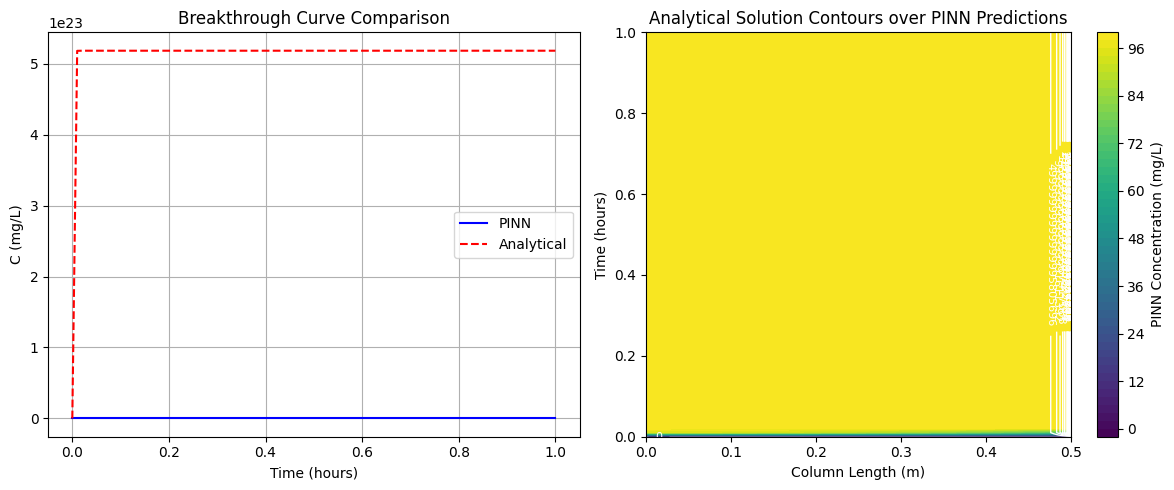

In [16]:
from scipy.special import erfc

# Generate predictions
x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x, t)
grid = np.vstack((X.flatten(), T_grid.flatten())).T
C_pred = model.predict(grid).reshape(X.shape)

# Corrected analytical solution with stability handling
epsilon = 1e-12  # Small value to prevent division by zero
C_analytical = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x_val = X[i,j]
        t_val = T_grid[i,j]

        if t_val == 0:
            C_analytical[i,j] = 0  # Enforce initial condition
        else:
            # Dimensionless parameters
            sqrt_term = np.sqrt(D*(t_val + epsilon)/(R*theta))
            arg1 = (x_val - v*(t_val + epsilon)/(R*theta)) / (2*sqrt_term)
            arg2 = (x_val + v*(t_val + epsilon)/(R*theta)) / (2*sqrt_term)

            term1 = 0.5 * np.exp(v*x_val/(2*D)) * erfc(arg1)
            term2 = 0.5 * np.exp(v*x_val/(2*D)) * erfc(arg2)
            C_analytical[i,j] = C0 * (term1 + term2)

# Breakthrough curves
outlet_idx = np.argmin(np.abs(x - L))

# Plotting
plt.figure(figsize=(12, 5))

# Breakthrough curve comparison
plt.subplot(1, 2, 1)
plt.plot(t/3600, C_pred[:, outlet_idx], 'b-', label='PINN')
plt.plot(t/3600, C_analytical[:, outlet_idx], 'r--', label='Analytical')
plt.xlabel('Time (hours)')
plt.ylabel('C (mg/L)')
plt.title('Breakthrough Curve Comparison')
plt.legend()
plt.grid(True)

# Contour plot comparison
plt.subplot(1, 2, 2)
cs1 = plt.contourf(X, T_grid/3600, C_pred, levels=50, cmap='viridis')
plt.colorbar(cs1, label='PINN Concentration (mg/L)')
cs2 = plt.contour(X, T_grid/3600, C_analytical, levels=10, colors='white', linewidths=1)
plt.clabel(cs2, inline=True, fontsize=8)
plt.xlabel('Column Length (m)')
plt.ylabel('Time (hours)')
plt.title('Analytical Solution Contours over PINN Predictions')

plt.tight_layout()
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.069245 s

'compile' took 1.111773 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.74e+02, 1.02e+04, 1.01e-05, 1.14e-02]    [1.80e-03, 1.02e+04, 1.01e-05, 1.14e-02]    []  
1000      [8.55e+00, 2.17e+03, 9.73e-04, 1.46e+00]    [4.04e-01, 2.17e+03, 9.73e-04, 1.46e+00]    []  
2000      [7.69e+00, 3.13e+02, 2.88e-03, 1.07e+00]    [6.10e-01, 3.13e+02, 2.88e-03, 1.07e+00]    []  
3000      [4.98e+00, 1.56e+01, 1.99e-02, 8.07e+00]    [1.50e+00, 1.56e+01, 1.99e-02, 8.07e+00]    []  
4000      [9.03e+00, 2.68e-01, 2.05e-02, 3.38e-01]    [2.27e+00, 2.68e-01, 2.05e-02, 3.38e-01]    []  
5000      [3.09e+00, 1.64e-01, 1.05e-02, 2.89e-02]    [1.65e+00, 1.64e-01, 1.05e-02, 2.89e-02]    []  
6000      [2.48e+00, 1.23e-01, 4.49e-03, 5.31e-03]    [1.17e+00, 1.23e-01, 4.49e-03, 5.31e-03]    []  
7000      [1.37e+00, 9.56e-02, 1.78e-03

<ipython-input-13-036ed702bb4b>:94: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  q_dynamic = (Q_flow / m_carbon) * trapz(C0 - breakthrough_curve, t)


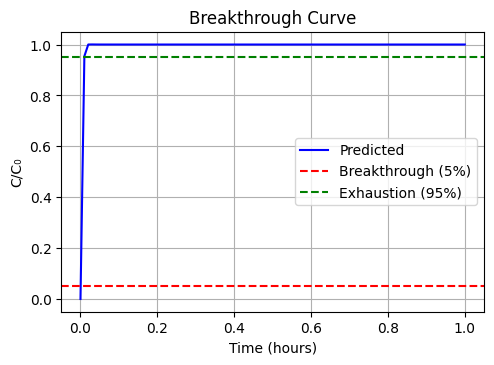

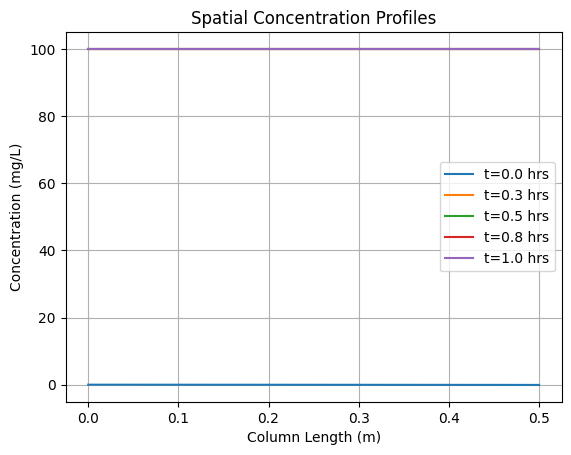

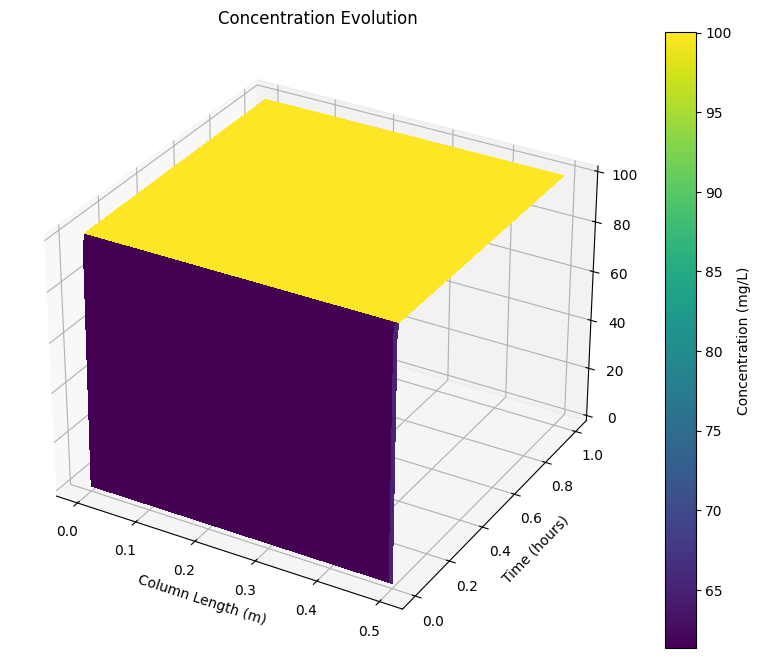


Performance Metrics:
Breakthrough time (t_b): 0.01 hours
Exhaustion time (t_e): 0.01 hours
Dynamic adsorption capacity: 311.82 mg/g
Utilization efficiency: 51969.8%


In [13]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption
D = 5e-5       # Dispersion coefficient [m²/s]
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Define temporal-spatial domain (optionally include scaling/transformation)
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE with proper porosity scaling
def pde(x, C):
    # Note: x[0]=x, x[1]=t
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)

    # Langmuir adsorption term (instantaneous equilibrium)
    dq_dC = q_max * K_L / (1 + K_L * C)**2
    dq_dt = dq_dC * dC_dt

    # Corrected PDE: note the division by theta for advection-dispersion terms
    return dC_dt - (D/theta)*d2C_dx2 + (v/theta)*dC_dx + (rho_b/theta)*dq_dt

# Boundary conditions
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,  # Initial concentration = 0 (clean bed)
    lambda x, _: np.isclose(x[1], 0)
)
bc_inlet = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet)
# For advection-dominated flows, a zero gradient at outlet is common.
bc_outlet = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet, bc_outlet, ic],
    num_domain=2000,
    num_boundary=200,
    num_initial=100,
    num_test=500
)

# Neural network architecture (considering further input scaling if needed)
net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Training: first Adam then L-BFGS for better convergence
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=1000)
model.compile("L-BFGS")
model.train()

# Prediction grid (consider normalizing if necessary)
x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x, t)
grid = np.vstack((X.flatten(), T_grid.flatten())).T
C_pred = model.predict(grid).reshape(X.shape)

# Breakthrough curve at column outlet
outlet_idx = np.argmin(np.abs(x - L))
breakthrough_curve = C_pred[:, outlet_idx]

# Calculate performance metrics (ensure consistent units; here t in seconds is converted to hours)
C_normalized = breakthrough_curve / C0
t_array = t / 3600

# Find breakthrough and exhaustion times
t_b = t[np.argmax(C_normalized >= 0.05)] / 3600
t_e = t[np.argmax(C_normalized >= 0.95)] / 3600

# Calculate dynamic adsorption capacity (check units; here we integrate time in seconds)
Q_flow = v * np.pi * (0.1)**2 * 3600  # [m³/hr] for a 10cm radius column
m_carbon = rho_b * np.pi * (0.1)**2 * L  # [kg]
q_dynamic = (Q_flow / m_carbon) * trapz(C0 - breakthrough_curve, t)

# Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t_array, C_normalized, 'b-', label='Predicted')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve')
plt.legend()
plt.grid(True)

num_time_points = C_pred.shape[0]
time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
plt.figure()
for ti in time_indices:
    plt.plot(x, C_pred[ti, :], label=f't={t[ti] / 3600:.1f} hrs')
plt.xlabel('Column Length (m)')
plt.ylabel('Concentration (mg/L)')
plt.title('Spatial Concentration Profiles')
plt.legend()
plt.grid(True)
plt.show()

# 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_grid/3600, C_pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('Column Length (m)')
ax.set_ylabel('Time (hours)')
ax.set_title('Concentration Evolution')
fig.colorbar(surf, ax=ax, label='Concentration (mg/L)')
plt.show()

# Print performance metrics
print(f"\nPerformance Metrics:")
print(f"Breakthrough time (t_b): {t_b:.2f} hours")
print(f"Exhaustion time (t_e): {t_e:.2f} hours")
print(f"Dynamic adsorption capacity: {q_dynamic:.2f} mg/g")
print(f"Utilization efficiency: {(q_dynamic/q_max)*100:.1f}%")

In [11]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption
D = 5e-5       # Dispersion coefficient [m²/s]
v = 0.01      # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Max adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Define temporal-spatial domain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE with Langmuir adsorption
def pde(x, C):
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)

    # Langmuir adsorption term
    dq_dt = (q_max * K_L / (1 + K_L * C)**2) * dC_dt

    return dC_dt - D*d2C_dx2 + v*dC_dx + (rho_b/theta)*dq_dt

# Boundary and initial conditions
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)  # x[0] = spatial coordinate

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Initial condition function
def initial_condition(x):
    return 0  # Clean bed at t=0

# Corrected IC with proper index handling
ic = dde.icbc.IC(
    geomtime,
    initial_condition,
    lambda x, _: np.isclose(x[1], 0)  # x[1] = temporal coordinate
)

bc_inlet = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet)
bc_outlet = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet, bc_outlet, ic],
    num_domain=2000,
    num_boundary=200,
    num_initial=100,
    num_test=500
)

# Neural network architecture
net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.089933 s

'compile' took 0.933965 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.74e+02, 1.02e+04, 1.10e-06, 1.14e-02]    [1.79e-03, 1.02e+04, 1.10e-06, 1.14e-02]    []  
1000      [7.91e+00, 2.18e+03, 5.81e-06, 6.08e+00]    [2.29e-01, 2.18e+03, 5.81e-06, 6.08e+00]    []  
2000      [1.01e+01, 3.33e+02, 1.97e-06, 4.10e+01]    [1.59e-01, 3.33e+02, 1.97e-06, 4.10e+01]    []  
3000      [9.59e+00, 1.72e+01, 3.69e-06, 7.34e-01]    [2.33e-01, 1.72e+01, 3.69e-06, 7.34e-01]    []  
4000      [7.90e+00, 6.90e-01, 7.55e-06, 4.66e-01]    [3.03e-01, 6.90e-01, 7.55e-06, 4.66e-01]    []  
5000      [5.62e+00, 5.58e-01, 5.71e-06, 1.91e-01]    [3.64e-01, 5.58e-01, 5.71e-06, 1.91e-01]    []  
6000      [3.65e+00, 5.47e-01, 8.55e-08, 6.28e-02]    [4.43e-01, 5.47e-01, 8.55e-08, 6.28e-02]    []  
7000      [2.40e+00, 4.98e-01, 2.09e-07

<ipython-input-12-5c98a0a83fb0>:23: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  q_dynamic = (Q/m_carbon) * trapz(C0 - breakthrough_curve, t)


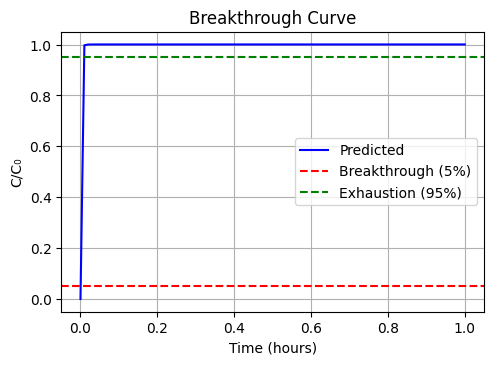

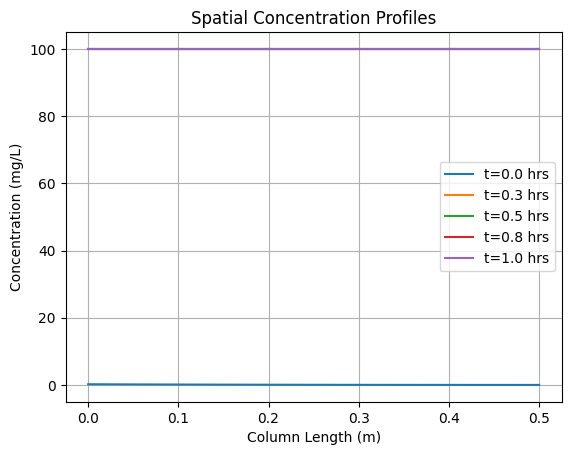

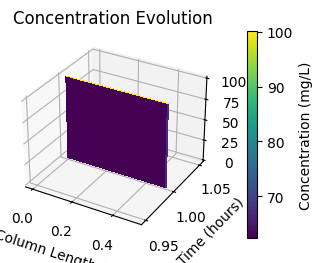


Performance Metrics:
Breakthrough time (t_b): 0.01 hours
Exhaustion time (t_e): 0.01 hours
Dynamic adsorption capacity: 0.00 mg/g
Utilization efficiency: 0.0%


In [12]:
# Generate prediction grid
x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)
X, T_grid = np.meshgrid(x, t)
grid = np.vstack((X.flatten(), T_grid.flatten())).T
C_pred = model.predict(grid).reshape(X.shape)

# Breakthrough curve at column outlet
outlet_idx = np.argmin(np.abs(x - L))  # Find outlet position
breakthrough_curve = C_pred[:, outlet_idx]

# Calculate performance metrics
C_normalized = breakthrough_curve / C0
t_array = t / 3600  # Convert to hours

# Find breakthrough and exhaustion times
t_b = t[np.argmax(C_normalized >= 0.05)] / 3600
t_e = t[np.argmax(C_normalized >= 0.95)] / 3600

# Calculate dynamic adsorption capacity
Q = v * np.pi*(0.1)**2 * 3600  # Flow rate [m³/hr], assuming 10cm column radius
m_carbon = rho_b * np.pi*(0.1)**2 * L  # Carbon mass [kg]
q_dynamic = (Q/m_carbon) * trapz(C0 - breakthrough_curve, t)

# Visualization
plt.figure(figsize=(12, 8))

# Breakthrough curve plot
plt.subplot(2, 2, 1)
plt.plot(t_array, C_normalized, 'b-', label='Predicted')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve')
plt.legend()
plt.grid(True)

# Generate corrected time indices
num_time_points = C_pred.shape[0]  # Number of time points in C_pred
time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]

# Plot spatial concentration profiles
plt.figure()
for ti in time_indices:
    plt.plot(x, C_pred[ti, :], label=f't={t[ti] / 3600:.1f} hrs')  # Convert seconds to hours
plt.xlabel('Column Length (m)')
plt.ylabel('Concentration (mg/L)')
plt.title('Spatial Concentration Profiles')
plt.legend()
plt.grid(True)
plt.show()


# 3D surface plot
plt.subplot(2, 2, (3,4), projection='3d')
surf = plt.gca().plot_surface(X, T/3600, C_pred, cmap='viridis',
                            linewidth=0, antialiased=False)
plt.xlabel('Column Length (m)')
plt.ylabel('Time (hours)')
plt.title('Concentration Evolution')
plt.colorbar(surf, label='Concentration (mg/L)')

plt.tight_layout()
plt.show()

# Print performance metrics
print(f"\nPerformance Metrics:")
print(f"Breakthrough time (t_b): {t_b:.2f} hours")
print(f"Exhaustion time (t_e): {t_e:.2f} hours")
print(f"Dynamic adsorption capacity: {q_dynamic:.2f} mg/g")
print(f"Utilization efficiency: {(q_dynamic/q_max)*100:.1f}%")

In [7]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Parameters for Hg²+ adsorption on activated carbon
D = 5e-5       # Dispersion coefficient [m²/s]
v = 0.01       # Pore water velocity [m/s]
rho_b = 450    # Bulk density [kg/m³]
theta = 0.45   # Porosity [-]
q_max = 0.6    # Maximum adsorption capacity [mg/g]
K_L = 0.15     # Langmuir constant [L/mg]
L = 0.5        # Column length [m]
T = 3600       # Total simulation time [s]
C0 = 100       # Inlet concentration [mg/L]

# Define temporal-spatial domain
geom = dde.geometry.Rectangle([0, 0], [L, T])
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Modified PDE with Langmuir adsorption
def pde(x, C):
    C, x, t = C[:, 0:1], x[:, 0:1], x[:, 1:2]

    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)

    # Langmuir adsorption term
    dq_dt = (q_max * K_L / (1 + K_L * C)**2) * dC_dt

    return dC_dt - D*d2C_dx2 + v*dC_dx + (rho_b/theta)*dq_dt

# Boundary and initial conditions
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Initial condition function
def initial_condition(x):
    return 0  # Clean bed at t=0

# Corrected IC with proper lambda signature
ic = dde.icbc.IC(
    geomtime,
    initial_condition,
    lambda x, _: np.isclose(x[:, 1], 0)  # x[:,1] = temporal coordinate
)

bc_inlet = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet)
bc_outlet = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_inlet, bc_outlet, ic],
    num_domain=2000,
    num_boundary=200,
    num_initial=100,
    num_test=500
)


# Neural network architecture
net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Training
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000, display_every=1000)

# Generate prediction grid
x = np.linspace(0, L, 100)
t = np.linspace(0, T, 100)
X, T = np.meshgrid(x, t)
grid = np.vstack((X.flatten(), T.flatten())).T
C_pred = model.predict(grid).reshape(X.shape)

# Breakthrough curve at column outlet
outlet_idx = np.argmin(np.abs(x - L))  # Find outlet position
breakthrough_curve = C_pred[:, outlet_idx]

# Calculate performance metrics
C_normalized = breakthrough_curve / C0
t_array = t / 3600  # Convert to hours

# Find breakthrough and exhaustion times
t_b = t[np.argmax(C_normalized >= 0.05)] / 3600
t_e = t[np.argmax(C_normalized >= 0.95)] / 3600

# Calculate dynamic adsorption capacity
Q = v * np.pi*(0.1)**2 * 3600  # Flow rate [m³/hr], assuming 10cm column radius
m_carbon = rho_b * np.pi*(0.1)**2 * L  # Carbon mass [kg]
q_dynamic = (Q/m_carbon) * trapz(C0 - breakthrough_curve, t)

# Visualization
plt.figure(figsize=(12, 8))

# Breakthrough curve plot
plt.subplot(2, 2, 1)
plt.plot(t_array, C_normalized, 'b-', label='Predicted')
plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
plt.xlabel('Time (hours)')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve')
plt.legend()
plt.grid(True)

# Spatial concentration profiles
plt.subplot(2, 2, 2)
for ti in [0, T//4, T//2, 3*T//4, T-1]:
    plt.plot(x, C_pred[ti,:], label=f't={t[ti]/3600:.1f} hrs')
plt.xlabel('Column Length (m)')
plt.ylabel('Concentration (mg/L)')
plt.title('Spatial Concentration Profiles')
plt.legend()
plt.grid(True)

# 3D surface plot
plt.subplot(2, 2, (3,4), projection='3d')
surf = plt.gca().plot_surface(X, T/3600, C_pred, cmap='viridis',
                            linewidth=0, antialiased=False)
plt.xlabel('Column Length (m)')
plt.ylabel('Time (hours)')
plt.title('Concentration Evolution')
plt.colorbar(surf, label='Concentration (mg/L)')

plt.tight_layout()
plt.show()

# Print performance metrics
print(f"\nPerformance Metrics:")
print(f"Breakthrough time (t_b): {t_b:.2f} hours")
print(f"Exhaustion time (t_e): {t_e:.2f} hours")
print(f"Dynamic adsorption capacity: {q_dynamic:.2f} mg/g")
print(f"Utilization efficiency: {(q_dynamic/q_max)*100:.1f}%")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#New

Compiling model...
Building feed-forward neural network...
'build' took 0.058519 s

'compile' took 0.535646 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.58e-03, 2.50e-01, 1.34e-03]    [1.53e-03, 2.50e-01, 1.34e-03]    []  
1000      [1.58e-06, 7.57e-11, 9.13e-12]    [8.81e-07, 7.57e-11, 9.13e-12]    []  
2000      [2.13e-07, 1.03e-12, 1.66e-10]    [1.47e-07, 1.03e-12, 1.66e-10]    []  
3000      [4.45e-08, 4.30e-11, 1.16e-08]    [1.88e-08, 4.30e-11, 1.16e-08]    []  
4000      [1.03e-08, 3.20e-14, 8.53e-12]    [8.05e-09, 3.20e-14, 8.53e-12]    []  
5000      [6.82e-09, 8.88e-16, 1.90e-12]    [5.58e-09, 8.88e-16, 1.90e-12]    []  

Best model at step 5000:
  train loss: 6.82e-09
  test loss: 5.58e-09
  test metric: []

'train' took 7.566113 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


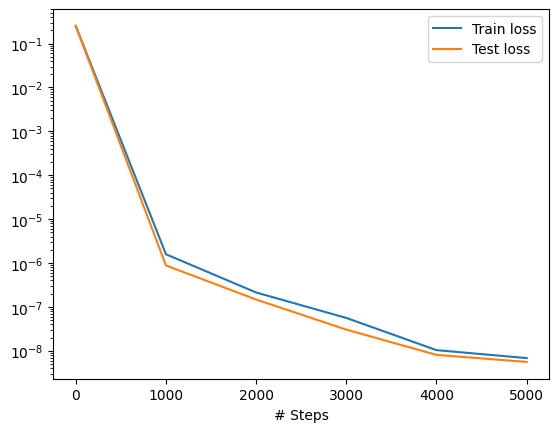

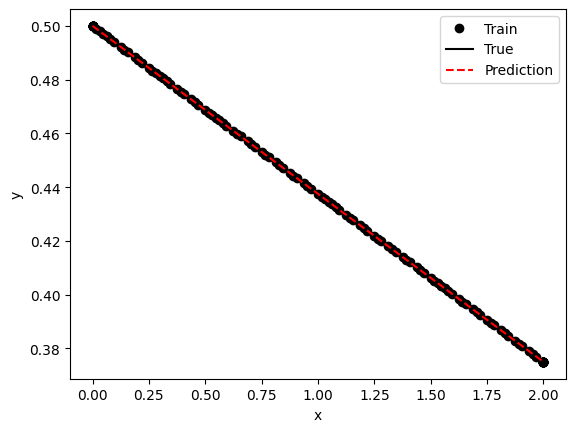

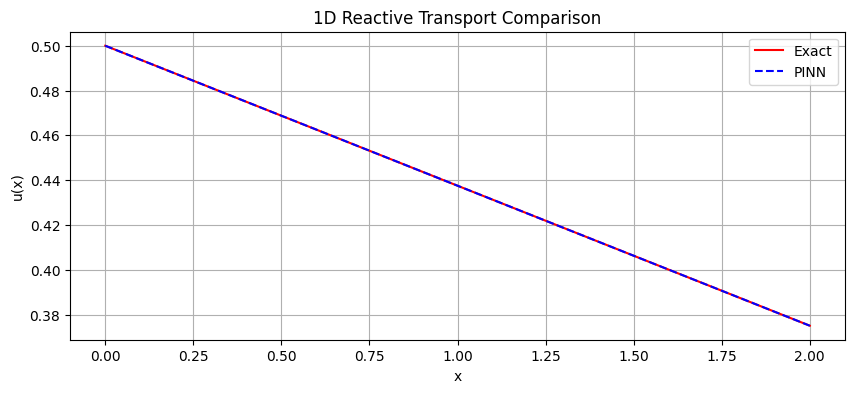

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# 1D domain
geom = dde.geometry.Interval(0, L)

def robin_func(inputs, outputs, X):
    du_dx = dde.grad.jacobian(outputs, inputs)
    return -D * du_dx - k * (alpha - outputs)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

bc_right = dde.icbc.OperatorBC(geom, robin_func, boundary_right)


# Dirichlet BC at left boundary
bc_left = dde.icbc.DirichletBC(geom, lambda x: u0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))

# PDE definition
def pde(x, u):
    du_xx = dde.grad.hessian(u, x)
    return D * du_xx

# Analytical solution
def exact_solution(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x

data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right],
    num_domain=100,
    num_boundary=20,
    solution=exact_solution,
    num_test=100,
)

net = dde.nn.FNN([1] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# Training
losshistory, train_state = model.train(iterations=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot results
x = np.linspace(0, L, 100).reshape(-1, 1)
u_pred = model.predict(x)
u_exact = exact_solution(x)

plt.figure(figsize=(10,4))
plt.plot(x, u_exact, '-r', label='Exact')
plt.plot(x, u_pred, '--b', label='PINN')
plt.xlabel('x'), plt.ylabel('u(x)')
plt.title('1D Reactive Transport Comparison')
plt.legend(), plt.grid(True)
plt.show()

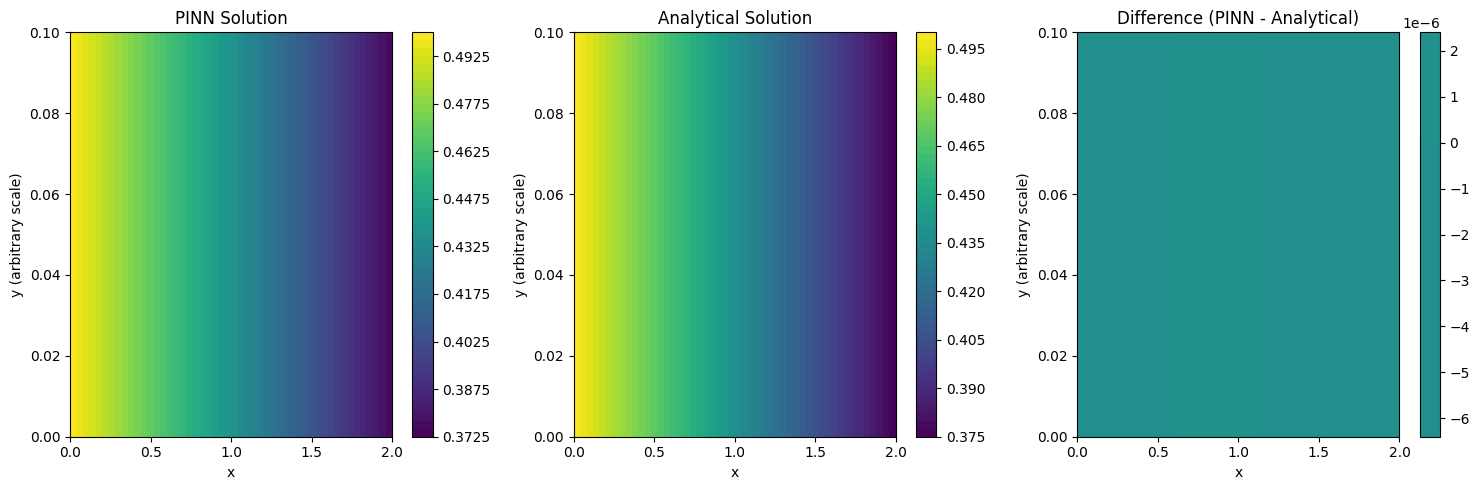

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# Generate grid points
x = np.linspace(0, L, 100)
y = np.linspace(0, 0.1, 20)
X, Y = np.meshgrid(x, y)

# Get PINN predictions (1D solution)
pinn_1d = model.predict(x.reshape(-1, 1)).flatten()  # Shape (100,)

# Analytical solution
def analytical(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x
analytic_1d = analytical(x)  # Shape (100,)

# Create 2D arrays by vertical tiling
Z_pinn_2d = np.tile(pinn_1d, (len(y), 1))  # Shape (20, 100)
Z_analytic_2d = np.tile(analytic_1d, (len(y), 1))  # Shape (20, 100)

# Calculate difference
difference = Z_pinn_2d - Z_analytic_2d

# Plotting
plt.figure(figsize=(15, 5))

# PINN Solution
plt.subplot(131)
plt.contourf(X, Y, Z_pinn_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PINN Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Analytical Solution
plt.subplot(132)
plt.contourf(X, Y, Z_analytic_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Analytical Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Difference Plot
plt.subplot(133)
plt.contourf(X, Y, difference, levels=50, cmap='viridis', vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference (PINN - Analytical)')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

plt.tight_layout()
plt.show()

#Old